# MNIST Autoencoder

We will use the MNIST dataset of handwritten digits [http://yann.lecun.com/exdb/mnist/] first to explore what autoencoders do. To begin, we need to load some python modules including common layers from keras.

In [1]:
# MNIST dataset
from keras.datasets import mnist

# numpy and pyplot
import numpy as np
import matplotlib.pyplot as plt

# keras
from keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model

/sw/apps/python3/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/sw/apps/python3/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/sw/apps/python3/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


We prepare the data by normalizing it.

Sincle we are doing unsupervised learning here, we will not need the labels provided by the dataset for now. We keep them however, as they will help with visualizing the results later.

There are 60k training and 10k test examples.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(x_train.shape)
print(x_test.shape)

11493376/11490434 [==============================] - 12s 1us/step
(60000, 28, 28)
(10000, 28, 28)


In priciple, an autoencoder consists of two models: the encoder and the decoder. To represent this, we are using keras' functional API where we can easily define models from component models.

We start by defining the encoder, whose output will be the latent space of the model. This latent space shall contain
32 floats. Storing just this data would yield a compression factor of 24.5, as  the input consists of $28\cdot28 = 784$ floats. Practically it is four times less, as the original images were 8-bit grayscale.

Then we define the decoder, which takes the latent image as input and produces full-size images again.

Finally, we chain encoder and decoder together to get our autoencoder.

## Shallow Autoencoder
First, we try a very shallow autoencoder with only one dense layer for each, the encoder and decoder.

In [3]:
# this is the size of our encoded representations
encodingDim = 32  # 

# this is our input placeholder
inputImg = Input(shape=x_train.shape[1:])
# encoder
x = Flatten()(inputImg)
x = Dense(encodingDim, activation='relu')(x)
encoder = Model(inputImg, x, name="encoder")
encoder.summary()

# this is our latent space placeholder
inputLat = Input(shape=encoder.output.shape.as_list()[1:])
# decoder
x = Dense(int(np.prod(inputImg.shape[1:])), activation='sigmoid')(inputLat)
x = Reshape(inputImg.shape[1:])(x)
decoder = Model(inputLat, x, name="decoder")
decoder.summary()

# this model maps an input to its reconstruction
autoencoder = Model(inputImg, decoder(encoder(inputImg)), name="generator")
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
_________________________________________________________________
reshap

In [4]:
# compile model using binary crossentropy loss
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [5]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 49us/step - loss: 0.3615 - val_loss: 0.2722
Epoch 2/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.2664 - val_loss: 0.2572
Epoch 3/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.2467 - val_loss: 0.2335
Epoch 4/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.2243 - val_loss: 0.2132
Epoch 5/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.2074 - val_loss: 0.1994
Epoch 6/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.1958 - val_loss: 0.1899
Epoch 7/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.1872 - val_loss: 0.1821
Epoch 8/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.1802 - val_loss: 0.1756
Epoch 9/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.1742 - val_loss: 0.1700
Epoch

Here we define a function to compare original and reconstructed images, which we will use later.

In [6]:
def showImages(ae, data):
    decoded_imgs = ae.predict(data)

    n = data.shape[0]  # how many digits we will display
    height = 20
    plt.figure(figsize=(height, height/n*2))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

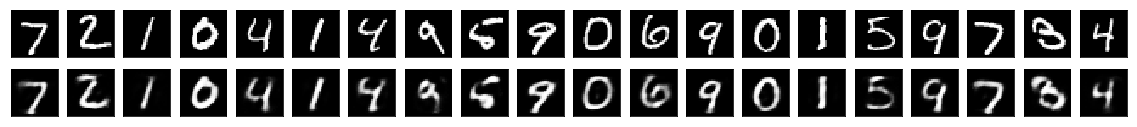

In [7]:
showImages(autoencoder, x_test[0:20])

## Multi-Layer Perceptron Autoencoder

Let us try a deeper network. This will have much more parameters as we use dense layers only, but it will give us better reconstructions after training for 50 epochs.

We will cut the latent space in half to get more compression (only use 16 float32 values), at the cost of some quality after traning only 50 epochs. So the improved reconstruction quality may not become a reality.

In [ ]:
def makeDeepMLPAE(encodingDim=16):
    # this is our input placeholder
    inputImg = Input(shape=x_train.shape[1:])
    x = Flatten()(inputImg)
    # encoder
    x = Dense(encodingDim*16, activation='relu')(x)
    x = Dense(encodingDim*8, activation='relu')(x)
    x = Dense(encodingDim*4, activation='relu')(x)
    x = Dense(encodingDim, activation='relu')(x)
    encoder = Model(inputImg, x, name="encoder")
    encoder.summary()

    # this is our latent space placeholder
    inputLat = Input(shape=encoder.output.shape.as_list()[1:])
    #decoder
    x = Dense(encodingDim*4, activation='relu')(inputLat)
    x = Dense(encodingDim*8, activation='relu')(inputLat)
    x = Dense(encodingDim*16, activation='relu')(inputLat)
    x = Dense(int(np.prod(inputImg.shape[1:])), activation='sigmoid')(x)
    x = Reshape(inputImg.shape[1:])(x) # remove channel dimension
    decoder = Model(inputLat, x, name="decoder")
    decoder.summary()

    # this model maps an input to its reconstruction
    autoencoder = Model(inputImg, decoder(encoder(inputImg)), name="generator")
    autoencoder.summary()
    
    return encoder, decoder, autoencoder

In [ ]:
encoder, decoder, autoencoder = makeDeepMLPAE(16)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


In [ ]:
showImages(autoencoder, x_test[0:20])

The reconstructions we obtain are still decent. Of course, longer training could perhaps improve the results. After training for another 50 epochs we would get better reconstruction than with the shallow example above.

## Latent Space Representation

The autoencoder effectively takes the 784 dimensional input data and tries to represent it in a 16 dimensional space (a vector of 16 floats).

We can visualize the latent space only by looking at it in fewer, i.e. two, dimensions. To this end we can perfom a principal component analysis (PCA) on the encoded images, to find a transform to a coordinate system, where as much of the variance in the encoded data is happening on as few axes as possible. We can than pick the two most important ones to project all points in latent space onto this plane.

We use the labels, indicating the digit to color each point.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
projection = pca.fit_transform(encoder.predict(x_test))
plt.scatter(projection[:,0], projection[:,1], c=y_test, cmap="rainbow")
plt.colorbar()
plt.show()

You see, that in this projection, the autoencoder apparently learned to separate between ones (blue) and zeros (violet) and has everything somewhere in between.

You can experiment with even smaller latent spaces, too.

We can also try to project on a 3D space:

In [ ]:
# try notbook mode so you can interactively rotate
#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)
projection = pca.fit_transform(encoder.predict(x_test))
p = ax.scatter(projection[:,0], projection[:,1], projection[:,2], c=y_test, cmap="rainbow")
fig.colorbar(p)
fig.show()

In [ ]:
# make sure to reset back to inline after trying notebook for 3D
%matplotlib inline

## Convolutional Autoencoder

Deep networks work well because of their ability to abstract. Going deeper with an MLP immensely increases the number of weight needing to be trained, leading to higher training cost and eventually overfitting.

So, we go to a convolutional autoencoder. We use a classical (AlexNet/GoogleNet) approach of using a set of convolutional units, extract features from the input image and use dense layers at the bottom to interpret these features. To produce an autoencoder we mirror the structure of the encoder in the decoder.

In this example we just use max-pooling in the encoder, upsampling in the decoder and standard 2D convolution throughout. An alternative would be to use strided 2D convolutions in the encoder and strided transpose 2D convolutions in the decoder.

Since our screen has only two dimensions, restrict the latent space to this, so we can better see what is going on. With this strong restriction we will not get as good reconstructions as before, but this more powerfull architecture should help us to still get something decent.

This network has much fewer trainable parameters than the previous one.

In [ ]:
# this is the size of our encoded representations
encodingDim = 2

# this is our input placeholder
inputImg = Input(shape=x_train.shape[1:])

# "encoded" is the encoded representation of the input
x = Reshape((*inputImg.shape.as_list()[1:],1))(inputImg)
x = Conv2D(4, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)
x = Conv2D(4, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = Conv2D(4, kernel_size=(3, 3), activation='relu', padding="same")(x)
cshape = x.shape.as_list()[1:]
x = Flatten()(x)
x = Dense(encodingDim*16, activation='relu')(x)
x = Dense(encodingDim*8, activation='relu')(x)
x = Dense(encodingDim*4, activation='relu')(x)
x = Dense(encodingDim, activation='relu')(x)
encoder = Model(inputImg, x, name="encoder")
encoder.summary()

# "decoded" is the lossy reconstruction of the input
inputLat = Input(shape=encoder.output.shape.as_list()[1:])
x = Dense(encodingDim*4, activation='relu')(inputLat)
x = Dense(encodingDim*8, activation='relu')(inputLat)
x = Dense(encodingDim*16, activation='relu')(inputLat)
x = Dense(int(np.prod(cshape)), activation='relu')(x)
x = Reshape(cshape)(x)
x = Conv2D(4, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = UpSampling2D(size=(2,2))(x)
x = Dropout(0.25)(x)
x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = Conv2D(4, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = UpSampling2D(size=(2,2))(x)
x = Dropout(0.25)(x)
x = Conv2D(4, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding="same")(x)
x = Reshape(inputImg.shape.as_list()[1:])(x)

decoder = Model(inputLat, x, name="decoder")
decoder.summary()

# this model maps an input to its reconstruction
autoencoder = Model(inputImg, decoder(encoder(inputImg)), name="generator")
autoencoder.summary()

In [ ]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=40,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Now we can look at the latent space directly.

We can see, that the encoder learned to decompse each digit into ints "one-ness" and its "zero-ness".

In [ ]:
%matplotlib inline

encoded = encoder.predict(x_test)
plt.scatter(encoded[:,0], encoded[:,1], c=y_test, cmap="rainbow")
plt.colorbar()
plt.show()

As we can guess from the higher loss, the reconstructions are less good then before. Notably, one can see, that this model seems to deny the existence of the digit "4" and always encodes these it as "9" instead.

In [ ]:
showImages(autoencoder, x_test[0:20])

We can train for more epochs to get slighlty better results. Doing this we can observe, that the separation between the classes in latent space improves.

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

encoded = encoder.predict(x_test)
plt.scatter(encoded[:,0], encoded[:,1], c=y_test, cmap="rainbow")
plt.colorbar()
plt.show()